In [1]:
import os
import sys
from contextlib import nullcontext
import cv2
from tqdm import tqdm
import torch
from PIL import Image
from einops import repeat
from pytorch_lightning import seed_everything
from torch import autocast

from common import replace_object
from common import parser, OmegaConf, load_model_from_config, latent_to_image, replace_object, \
    load_img, make_dataset_txt, data_to_dict

lldm_dir = os.path.abspath('./')
sys.path.append(lldm_dir)
from ldm.models.diffusion.ddim import DDIMSampler


# prepare
config = OmegaConf.load('configs/stable-diffusion/v1-inference.yaml')
model = load_model_from_config(config, 'models/ldm/stable-diffusion-v1/model.ckpt')
device = torch.device("cuda")
model = model.to(device)
model.model.diffusion_model.register_fusion_func('replace')
sampler = DDIMSampler(model)
seed_everything(42)
model.cond_stage_model = model.cond_stage_model.to(device)
precision_scope = autocast

Loading model from models/ldm/stable-diffusion-v1/model.ckpt
Global Step: 470000
LatentDiffusion: Running in eps-prediction mode
DiffusionWrapper has 859.52 M params.
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 4, 32, 32) = 4096 dimensions.
making attention of type 'vanilla' with 512 in_channels


Some weights of the model checkpoint at openai/clip-vit-large-patch14 were not used when initializing CLIPTextModel: ['text_projection.weight', 'vision_model.encoder.layers.1.self_attn.q_proj.bias', 'vision_model.encoder.layers.22.mlp.fc1.weight', 'vision_model.encoder.layers.5.self_attn.q_proj.bias', 'vision_model.encoder.layers.1.self_attn.q_proj.weight', 'vision_model.encoder.layers.21.mlp.fc2.bias', 'vision_model.encoder.layers.8.self_attn.v_proj.weight', 'vision_model.encoder.layers.15.mlp.fc1.bias', 'vision_model.encoder.layers.0.mlp.fc2.bias', 'vision_model.encoder.layers.1.self_attn.k_proj.bias', 'vision_model.encoder.layers.6.layer_norm2.weight', 'vision_model.encoder.layers.16.layer_norm1.bias', 'vision_model.encoder.layers.10.self_attn.k_proj.bias', 'vision_model.encoder.layers.1.self_attn.v_proj.bias', 'vision_model.encoder.layers.18.self_attn.k_proj.weight', 'vision_model.encoder.layers.19.mlp.fc2.weight', 'vision_model.embeddings.position_embedding.weight', 'vision_model.

Global seed set to 42


In [4]:
import numpy as np
def get_mask_dilate(root_dir, name, dilate_args=None):
    img_mask = cv2.imread(os.path.join(root_dir, 'masks/%s.png' % name), cv2.IMREAD_GRAYSCALE)
    img_mask = img_mask / 255
    img_mask[img_mask !=0] = 1
    if dilate_args is not None:
        kernel = np.ones((dilate_args[0], dilate_args[0]), dtype=np.uint8)
        img_mask = cv2.dilate(img_mask, kernel, dilate_args[1])
    img_mask = cv2.resize(img_mask, (64, 64), interpolation=cv2.INTER_LANCZOS4)
    img_mask[img_mask > 0.5] = 1
    img_mask[img_mask !=1] = 0
    img_mask = torch.Tensor(img_mask).unsqueeze(0).unsqueeze(0).cuda()
    return img_mask

In [5]:
DDIM_STEPS=50
root_dir = 'demo/' # specify the directory where input images and their masks are stored
prompts_dict = data_to_dict(make_dataset_txt('demo/orig_prompt.txt')) # the original prompts
sampler.make_schedule(ddim_num_steps=DDIM_STEPS, ddim_eta=0.0, verbose=False)

In [58]:
################################# object replace ############################################
# Specify the layers where Progressive Feature Blending (PFB) is applied.
fusion_layers = {
    "encoder": [7, 8, 9, 10, 11],  
    "middle": True,
    "decoder": [12, 13, 14, 15, 16]
}
# Specify the layers where Attention Masking (AM) is applied.
attn_layers = {
    "encoder": [],
    "decoder": [],
}
# We set the starting time for the sampling process to t=1000 and end at t=0
# ============================  specifiy hyper parameters  ==================================
t_combine = 0 #  We apply PFB for timesteps between [1000, t_combine]
self_replace_step = 0.4 # we apply pixel-level blending for timesteps between [1000, 1000*self_replace_step],
#  You can adjust 'self_replace_step' as needed to achieve better results.
masked_attn = False # Set to False for object replace
init_rand = False # If True, the sampling process starts from random noise, enabling diverse results; 
# If False, sample process start from the result of ddim encoding with ratio=RATIO
RATIO = 1 # Encoding ratio for ddim encoding
# ============================  starting sampling  ==================================
edit_prompts = {
    0: "a duck",
    1: "a pencil drawing of a river", # a pencil drawing of landscape
    2: "river in Hayao Miyazaki style",
    3: "two real birds", # "crochet birds", "origami birds", set RATIO=0.8
    5: "a tiger",
    7:"A robot",
    8: "a dog",
    9: "an owl",
    10: "a monster cake", # set RATIO=0.8, you can adjust this parameter as needed to achieve better results.
    12: "red hat",
    13: "white straight hair",
    14: "a mushroom",
    15: "a few white roses",
    16: "blue leather jacket", # set RATIO=0.8
    18: "a rabbit",
    19: "a teddy bear"
}

replace_list = [0]

out_dir = os.path.join('figures', 'ours-fore')
os.makedirs(out_dir, exist_ok=True)

with torch.no_grad():
    with precision_scope(device.type):
        with model.ema_scope():
            for name in replace_list:
                # load image and mask
                name = str(name)
                img_path = os.path.join(root_dir, 'img_dir/%s.png' % name)
                tgt_image = repeat(
                    load_img(img_path, 512, 512).cuda(), '1 ... -> b ...', b=1)
                prompt = prompts_dict[name]
                edit_prompt = edit_prompts[int(name)]
                print(edit_prompt)
                tgt_mask = get_mask_dilate(root_dir, name)

                # define model_kwargs
                model_kwargs = {}
                model_kwargs['fusion_layers'] = fusion_layers
                model_kwargs["t_combine"] = t_combine
                model_kwargs["tgt_mask"] = tgt_mask
                model_kwargs["ref_mask"] = None
                model_kwargs["attn_mask"] = {
                    'attn_mask': tgt_mask.clone(),
                    'words': [[], []]
                } if masked_attn else None

                model_kwargs["attn_layers"] = attn_layers
                model_kwargs["self_replace_step"] = self_replace_step
                # get text conditions
                uc = model.get_learned_conditioning([""])
                src_cond = model.get_learned_conditioning([prompt])
                tgt_cond = model.get_learned_conditioning([edit_prompt])
                # get noisy images
                t_enc = int(DDIM_STEPS * RATIO)
                ref_latent = model.get_first_stage_encoding(
                    model.encode_first_stage(tgt_image))
                ref_latents = sampler.ddim_loop(ref_latent, src_cond, t_enc)

                def corrector_fn(x, index):
                    if index / DDIM_STEPS > model_kwargs['self_replace_step']:
                        x = x * tgt_mask + (1 - tgt_mask) * ref_latents[index]
                    return x

                # sampling
                num_samples = 1 # It is possible to sample multiple times and select the preferred result.

                for ii in range(num_samples):
                    if init_rand:
                        init_latent = torch.load('rands/%d.pt' % ii).cuda()
                    else:
                        init_latent = ref_latents[-1].clone()

                    recover_latent = sampler.ddim_replace_object(init_latent, ref_latents, src_cond, tgt_cond, t_enc,
                                                                 unconditional_guidance_scale=7.5,
                                                                 unconditional_conditioning=uc,
                                                                 corrector_fn=corrector_fn,
                                                                 model_kwargs=model_kwargs)

                    res = latent_to_image(model, recover_latent)
                    Image.fromarray(res[0]).save(
                        out_dir + '/%s_%d.png' % (name, ii))

a duck


Encoding image: 100%|███████████████████████████| 50/50 [00:03<00:00, 14.22it/s]


Running DDIM Sampling with 50 timesteps


Decoding image: 100%|███████████████████████████| 50/50 [00:10<00:00,  4.70it/s]


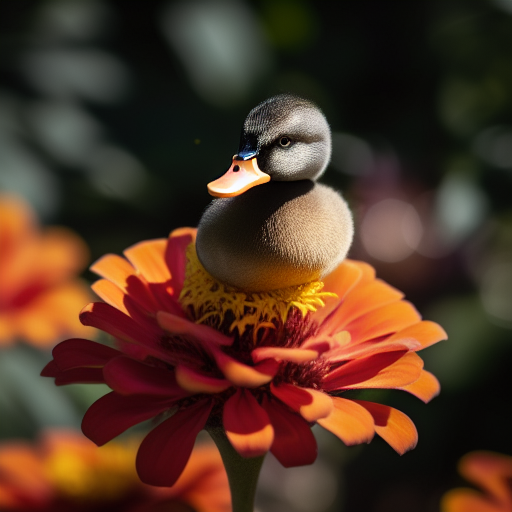

In [59]:
Image.fromarray(res[0])

In [17]:
words_dict = {
    '6': [[], [1, 2, 3, 4]],
    '11': [[], [1, 2, 3,4]],
    '20': [[], [1, 2, 3, 4]],
}

In [69]:
################################# back replace ############################################
fusion_layers = {
    "encoder": [7, 8, 9, 10, 11],
    "middle": True,
    "decoder": [12, 13, 14, 15, 16, 17]
}
attn_layers = {
    "encoder": [4, 5, 6, 7, 8, 9, 10, 11],
    "decoder": [12, 13, 14, 15, 16, 17, 18, 19,20],
}
t_combine = 200
self_replace_step = 0.8
masked_attn = True
init_rand = True # It is advisable to set init_rand to True, allowing multiple samples to choose the preferred result.
RATIO = 1
# ============================  back replace  ==================================
edit_prompts = {
    6: "A happy corgi running on the grass",
}
replace_list = [6]


out_dir = os.path.join('figures', 'ours-back')
os.makedirs(out_dir, exist_ok=True)

with torch.no_grad():
    with precision_scope(device.type):
        with model.ema_scope():
            for name in replace_list:
                # load image and mask
                name = str(name)
                img_path = os.path.join(root_dir, 'img_dir/%s.png' % name)
                tgt_image = repeat(
                    load_img(img_path, 512, 512).cuda(), '1 ... -> b ...', b=1)
#                 prompt = prompts_dict[name]
                
                prompt = 'a few of people standing on the ground'
                edit_prompt = edit_prompts[int(name)]
                print(edit_prompt)
                tgt_mask = 1 - get_mask_dilate(root_dir, name,[1,1])
                # define model_kwargs

                model_kwargs = {}
                model_kwargs['fusion_layers'] = fusion_layers
                model_kwargs["t_combine"] = t_combine
                model_kwargs["tgt_mask"] = tgt_mask
                model_kwargs["ref_mask"] = None
                model_kwargs["attn_mask"] = {
                    'attn_mask': tgt_mask.clone(),
                    'words': words_dict[name]
                } if masked_attn else None

                # print(model_kwargs["attn_mask"])
                model_kwargs["attn_layers"] = attn_layers
                model_kwargs["self_replace_step"] = self_replace_step

                # get text conditions

                uc = model.get_learned_conditioning([""])
                src_cond = model.get_learned_conditioning([prompt])
                tgt_cond = model.get_learned_conditioning([edit_prompt])

                # get noisy images

                t_enc = int(DDIM_STEPS * RATIO)
                ref_latent = model.get_first_stage_encoding(
                    model.encode_first_stage(tgt_image))
                ref_latents = sampler.ddim_loop(ref_latent, src_cond, t_enc)

                def corrector_fn(x, index):
                    if index / DDIM_STEPS > model_kwargs['self_replace_step']:
                        x = x * tgt_mask + (1 - tgt_mask) * ref_latents[index]
                    return x

                # sampling
                num_samples = 20

                for ii in range(num_samples):
                    if init_rand:
                        init_latent = torch.load('rands/%d.pt' % ii).cuda()
                    else:
                        init_latent = ref_latents[-1].clone()
                    recover_latent = sampler.ddim_replace_object(init_latent, ref_latents, src_cond, tgt_cond, t_enc,
                                                                 unconditional_guidance_scale=7.5,
                                                                 unconditional_conditioning=uc,
                                                                 corrector_fn=corrector_fn,
                                                                 model_kwargs=model_kwargs)

                    res = latent_to_image(model, recover_latent)
                    Image.fromarray(res[0]).save(
                        out_dir + '/%s_%d.png' % (name, ii))

A happy corgi running on the grass


Encoding image: 100%|███████████████████████████| 50/50 [00:05<00:00,  9.67it/s]


Running DDIM Sampling with 50 timesteps


Decoding image: 100%|███████████████████████████| 50/50 [00:11<00:00,  4.26it/s]


Running DDIM Sampling with 50 timesteps


Decoding image: 100%|███████████████████████████| 50/50 [00:11<00:00,  4.25it/s]


Running DDIM Sampling with 50 timesteps


Decoding image: 100%|███████████████████████████| 50/50 [00:11<00:00,  4.26it/s]
